# Schools in Greenville, SC, How are they similar? 

First do data preprocessing in the "School_data_preprocessing" notebook.


The data sources are:

2015-2016 graduation rates: https://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html#acgr

2015-2016 school location, characteristics, staff, and lunch programs: https://nces.ed.gov/ccd/pubschuniv.asp

2015-2016 school achievement: https://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html#acgr

2015-2016 suspenion rates: https://ocrdata.ed.gov/DataAnalysisTools/DataSetBuilder?Report=4
for this analysis, we only focused on the greenville district schools, but you could select other areas of interest.
    

In [111]:
import numpy as np
import pandas as pd
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#Import data that has already been cleaned
path='/home/natalie/Documents/SchoolAPI/CleanedData/'

all_data=pd.read_csv(path+'all_data.csv', parse_dates=True) #includes school membership, math and reading scores

grad_all_data=pd.read_csv(path+'grad_all_data.csv', parse_dates=True)#includes school membership, math and reading scores, but since graduation rates are limited to high schools, this data is high school specific 

suspensions_all_data=pd.read_csv(path+'suspensions_all_data.csv', parse_dates=True) #includes all of the school membership, math and reading scores, but since suspensions were for Greenville County only, this data is limited to Greenville.

suspensions_grad_greenville=pd.read_csv(path+'suspensions_grad_greenville.csv', parse_dates=True)#graduation high school rates, plus suspensions in Greenville only

## The "All_Cohort" variable is all students in that school, then they are broken down into racial groups.

MAM = American Indian/Alaska Native students

MAS = Asian/Pacific Islander

MHI = Hispanic/Latino

MBL = Black

MWH = White

MTR = Two or more races

CWD = disabilities

ECD = Economically disadvanted

LEP = Limited English Proficiency

Double check that all missing values are correctly filled in or removed prior to clustering algorithims which cannot handle NAs

In [112]:
na_list=grad_all_data.isna().sum()
na_list/len(grad_all_data) # percentage
#Because many of these race groups are so small the PS identifier was used, and then converted to NA.

Unnamed: 0             0.0
FIPST                  0.0
NCESSCH                0.0
LCITY                  0.0
LZIP                   0.0
G1OFFERED              0.0
G8OFFERED              0.0
G12OFFERED             0.0
NOGRADES               0.0
type_school            0.0
SCH_NAME_n_students    0.0
G01_n_students         0.0
G08_n_students         0.0
G12_n_students         0.0
TOTAL_n_students       0.0
AM_n_students          0.0
AMALM_n_students       0.0
AMALF_n_students       0.0
AS_n_students          0.0
ASALM_n_students       0.0
ASALF_n_students       0.0
HI_n_students          0.0
HIALM_n_students       0.0
HIALF_n_students       0.0
BL_n_students          0.0
BLALM_n_students       0.0
BLALF_n_students       0.0
WH_n_students          0.0
WHALM_n_students       0.0
WHALF_n_students       0.0
                      ... 
F_RLA00PCTPROF         0.0
M_RLA00NUMVALID        0.0
M_RLA00PCTPROF         0.0
MBL_RLAHSNUMVALID      0.0
MBL_RLAHSPCTPROF       0.0
MWH_RLAHSNUMVALID      0.0
M

(array([ 277.,  572.,  419.,  462.,  114., 1932.,  909., 2581., 5649.,
        8752.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <a list of 10 Patch objects>)

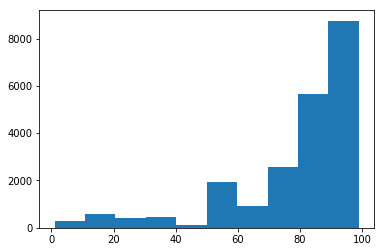

In [113]:
plt.hist(grad_all_data['ALL_RATE']) #most schools have above 80% graduation, but there is some negative skewing down towards lower rates.

Let's see how school suspensions correlate with graduation rates.
Plot the percentage of total students graduating vs the total number of suspensions for that group

In [114]:
suspensions_grad_greenville.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 83 columns):
Unnamed: 0                19 non-null int64
FIPST                     19 non-null int64
NCESSCH                   19 non-null int64
LCITY                     19 non-null object
LZIP                      19 non-null int64
G1OFFERED                 19 non-null int64
G8OFFERED                 19 non-null int64
G12OFFERED                19 non-null int64
NOGRADES                  19 non-null int64
type_school               19 non-null object
SCH_NAME_n_students       19 non-null object
G01_n_students            19 non-null int64
G08_n_students            19 non-null int64
G12_n_students            19 non-null int64
TOTAL_n_students          19 non-null int64
AM_n_students             19 non-null int64
AMALM_n_students          19 non-null int64
AMALF_n_students          19 non-null int64
AS_n_students             19 non-null int64
ASALM_n_students          19 non-null int64
ASALF_n_studen

Text(0,0.5,'rate of graduation (%)')

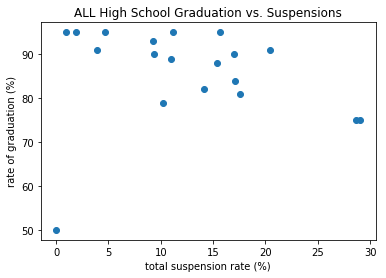

In [115]:
plt.scatter(suspensions_grad_greenville['TOT_OSS_rate'],  suspensions_grad_greenville['ALL_RATE'])
plt.title('ALL High School Graduation vs. Suspensions')
plt.xlabel('total suspension rate (%)')
plt.ylabel('rate of graduation (%)')

### Math competence vs. suspensions for all students

Text(0,0.5,'percentage of all students proficient in math')

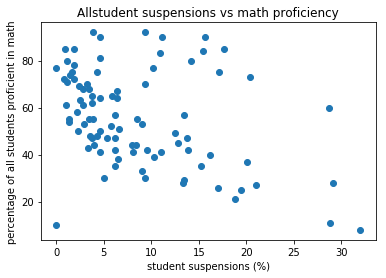

In [116]:
plt.scatter(suspensions_all_data['TOT_OSS_rate'],  suspensions_all_data['ALL_MTH00PCTPROF'])
plt.title('Allstudent suspensions vs math proficiency')
plt.xlabel('student suspensions (%)')
plt.ylabel('percentage of all students proficient in math')

This has a trend we expect, as the number of suspensions increases the % of students proficient in math tends to decrease

## Let's compare suspension rate by race. 
When there is a very small group of students, the data is removed to protect privacy. Thus, there are many instances where the rates are shown as "0". Therefore, for this analysis we will remove these "0" entries.


In [70]:
susp_list=['TOT_OSS_rate', 'BLA_OSS_rate', 'WHI_OSS_rate']
suspensions_all_data_zerorm=suspensions_all_data
for i in susp_list:
    suspensions_all_data_zerorm=suspensions_all_data_zerorm[suspensions_all_data_zerorm[i] !=0]


In [123]:
#suspensions_trans1=[]
tot_oss=pd.DataFrame(columns=['OSS_rate','type'])
tot_oss['OSS_rate']=suspensions_all_data_zerorm['TOT_OSS_rate'][0:89,]
tot_oss['type']='Total'
tot_oss=tot_oss.iloc[:-1] #unclear why it adds a 'total' to the bottom in the rate column


,OSS_rate,type


In [124]:
BLA_oss=pd.DataFrame(columns=['OSS_rate','type'])
BLA_oss['OSS_rate']=suspensions_all_data_zerorm['BLA_OSS_rate']
BLA_oss['type']='BLA'

WH_oss=pd.DataFrame(columns=['OSS_rate','type'])
WH_oss['OSS_rate']=suspensions_all_data_zerorm['WHI_OSS_rate']
WH_oss['type']='WHI'

oss_race_rate=pd.concat([tot_oss, BLA_oss, WH_oss])
oss_race_rate['OSS_rate']=oss_race_rate['OSS_rate'].astype(str).astype(float)

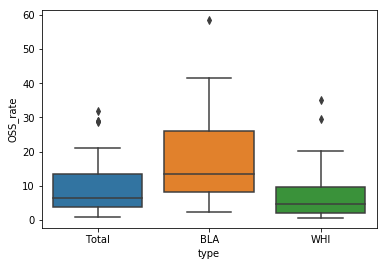

In [125]:
import seaborn as sns
# Make boxplot for one group only

sns.boxplot( y=oss_race_rate['OSS_rate'], x=oss_race_rate['type'])

It appears the suspension rate of black students is higher than white students, let's check the statstical significane.

In [131]:
#ANOVA to compare the three groups of suspension rates

#first create simple linear regression only using the type of race as a predictor
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('OSS_rate ~ type', oss_race_rate).fit()

print(model.summary())  

                            OLS Regression Results                            
Dep. Variable:               OSS_rate   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     35.97
Date:                Wed, 05 Sep 2018   Prob (F-statistic):           1.89e-14
Time:                        14:44:18   Log-Likelihood:                -896.57
No. Observations:                 252   AIC:                             1799.
Df Residuals:                     249   BIC:                             1810.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.1490      0.932     18.403

In [133]:
#ANOVA table

aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
type,5248.236006,2.0,35.973879,1.886873e-14
Residual,18163.328646,249.0,NaN,NaN


#### Do suspensions rates for different races, correlate with math competence?

suspensions are shown in 'times white', which indicates afor example, suspension for black students are 4X higher than white students.

MBL_MTHHSPCTPROF = percentage of black students in school who are proficient in math
BLA_OSS_times_white = suspension rate of black students comapred to whtie students

Text(0,0.5,'percentage of group proficient in math')

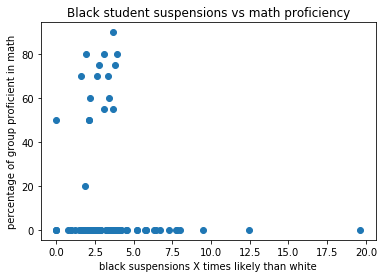

In [42]:
plt.scatter(suspensions_all_data['BLA_OSS_times_white'],  suspensions_all_data['MBL_MTHHSPCTPROF'])
plt.title('Black student suspensions vs math proficiency')
plt.xlabel('black suspensions X times likely than white')
plt.ylabel('percentage of group proficient in math')

Text(0,0.5,'percentage of group proficient in reading')

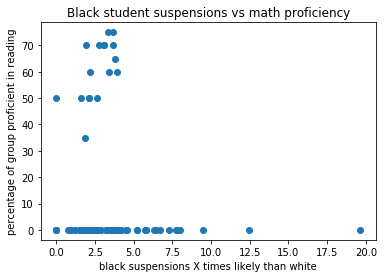

In [44]:
plt.scatter(suspensions_all_data['BLA_OSS_times_white'],  suspensions_all_data['MBL_RLAHSPCTPROF'])
plt.title('Black student suspensions vs math proficiency')
plt.xlabel('black suspensions X times likely than white')
plt.ylabel('percentage of group proficient in reading')
#there are many missing data points, coded here as '0' for proficient, so that doesn't help our analysis much

In [40]:
suspensions_all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 69 columns):
Unnamed: 0                90 non-null int64
FIPST                     90 non-null int64
NCESSCH                   90 non-null int64
LCITY                     90 non-null object
LZIP                      90 non-null int64
G1OFFERED                 90 non-null int64
G8OFFERED                 90 non-null int64
G12OFFERED                90 non-null int64
NOGRADES                  90 non-null int64
type_school               90 non-null object
SCH_NAME_n_students       90 non-null object
G01_n_students            90 non-null int64
G08_n_students            90 non-null int64
G12_n_students            90 non-null int64
TOTAL_n_students          90 non-null int64
AM_n_students             90 non-null int64
AMALM_n_students          90 non-null int64
AMALF_n_students          90 non-null int64
AS_n_students             90 non-null int64
ASALM_n_students          90 non-null int64
ASALF_n_studen

### First look at clustering based on graduation rates only, also broken down by race

In [ ]:
#We do not need the school name, NCESSCH, FIPST, or LEAID variables in clustering. We also remove the statename and leanm
cluster_data=grad_2015.drop(['NCESSCH', 'FIPST', 'LEAID', 'SCHNAM', 'DATE_CUR', 'STNAM', 'LEANM'], axis=1)
cluster_data.head()

In [ ]:
## Start with Principal Component Analysis (PCA) to visuzlize data and see if there are any clusters

PCA takes all of the data variables for each datapoint, and trys to create n axis (usually 2-3) that summarizes all of that variability into a meaningful way. Example, if we start with 10 variables, we could condense this down into 2 variables and then plot the data on these new 2 variable axes (like an x-y axis plot).


In [ ]:
# 1. Use StandardScaler to help you standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) 
from sklearn.preprocessing import StandardScaler

# Standardizing the features
cluster_data.iloc[:, 2:] = StandardScaler().fit_transform(cluster_data.iloc[:, 2:])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(cluster_data)

principalDf = pd.DataFrame(data = principalComponents
            , columns = ['principal component 1', 'principal component 2'])

In [ ]:
principalDf.head()

plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'], s=50)

In [ ]:
from sklearn.cluster import KMeans
#do k-means clustering on 2 components created earlier
labels = KMeans(2, random_state=0).fit_predict(principalDf)
labels

In [ ]:
principalDf['kmeans']=labels
plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'], s=50, c=labels)

In [ ]:
cluster_data['kmeans']=labels
grad_2015['kmeans']=labels

Let's see how the cluster classification compares across different graduating trends by race

In [ ]:
grad_2015[['kmeans', 'ALL_RATE_1516', 'MBL_RATE_1516']].groupby(['kmeans'], as_index=False).mean()

In [ ]:
Clustering on just the graduation data did not seem to help, let's see if pulling in other data will improve our model.
